In [35]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import os
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input , Conv1D , InputLayer
from tensorflow.keras import models

<Strong> Grabbing the data from stored files (originally pulled from Binance) </Strong>

In [36]:
df_xrp = pd.read_csv("../../../cryptoData/XRP_1h_data.csv")

In [37]:
df_xrp

,date,open,high,low,close,volume
0,2018-05-04 08:00:00,0.50000,1.50000,0.5000,0.92300,5090857.33
1,2018-05-04 09:00:00,0.92300,0.92850,0.9010,0.90199,3326696.10
2,2018-05-04 10:00:00,0.90199,0.91027,0.8951,0.90128,1176810.48
3,2018-05-04 11:00:00,0.90128,0.92130,0.8800,0.91596,1714233.92
4,2018-05-04 12:00:00,0.91596,0.92450,0.9000,0.90098,1323800.17
...,...,...,...,...,...,...
33012,2022-02-11 10:00:00,0.81860,0.82180,0.8105,0.81860,13705481.00
33013,2022-02-11 11:00:00,0.81850,0.82080,0.8138,0.81510,7748847.00
33014,2022-02-11 12:00:00,0.81510,0.82120,0.8125,0.81660,16123801.00
33015,2022-02-11 13:00:00,0.81650,0.83390,0.8147,0.82320,24000643.00


In [38]:
df_headers = df_xrp.columns

<Strong> Grabbing the closing price (univariate) </Strong>

In [39]:
# Removing everything but the closing price
xrp_data = df_xrp.values[:, 4 ,].astype(float)

len(xrp_data)

33017

<Strong> Scaling the data  </Strong>

In [40]:
percTrain = 70
percVal = 20 

In [41]:
onePercent = len(xrp_data) // 100
numberTraining = onePercent * percTrain

scaler = MinMaxScaler()
reshaped_data = xrp_data.reshape(-1,1)

#Just scaling on training data otherwise it would be leakage
scaler.fit(reshaped_data[:numberTraining])
scaled_xrp = scaler.transform(reshaped_data)

<Strong> Creating Matrix in Sliding window form <Strong>

In [42]:
def sliding_window(elements, window_size):
    
    data = [] 
    targets = []
    
    if len(elements) <= window_size:
        return elements
    
    for i in range(len(elements) - window_size ):
        
        data.append(elements[i:i+window_size])
        targets.append(elements[i+window_size])
        
    return np.array(data) , np.array(targets)

In [43]:
window_length = 24
features = 1

sliding_winda_xrp = sliding_window(scaled_xrp , window_length)

<Strong> Splitting the data after we create Sliding Window matrix (more data) </Strong>

In [44]:
# Splitting the data after creating the sliding window data

def splitting_train_test(data):
        
    onePercent = len(data[1]) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[0][:numberTraining] , data[1][:numberTraining]
    validationData = data[0][numberTraining : numberTraining + numberValidation] , data[1][numberTraining : numberTraining + numberValidation]
    testData = data[0][numberTraining + numberValidation:] , data[1][numberTraining + numberValidation:] 
    
    #Returning tuples of (sliding-window , target_values)
    return trainingData , validationData , testData

In [45]:
#Reshaping the data so we can use min-max a
xrp_train , xrp_val , xrp_test = splitting_train_test(sliding_winda_xrp)

print(xrp_train[0].shape)

(23030, 24, 1)


<Strong> Creating the model </Strong>

In [46]:
inputs = Input(shape = (window_length , features) )

#From deep learning in python -- better to use recurrent dropout so error propergates correctly
x = LSTM(30 , return_sequences = True)(inputs)
x = Dropout(0.2)(x) 
x = LSTM(50)(x)
x = Dropout(0.2)(x) 
x = Dense(16)(x)

y = GRU(30 , input_shape=(window_length , features))(inputs)
y = Dropout(0.5)(y)
y = Dense(16)(y)

final = Concatenate()([x,y])
final = Dense(1)(final)

model = tf.keras.Model(inputs=inputs, outputs= final)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 24, 1)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 24, 30)       3840        ['input_2[0][0]']                
                                                                                                  
 dropout_3 (Dropout)            (None, 24, 30)       0           ['lstm_2[0][0]']                 
                                                                                                  
 lstm_3 (LSTM)                  (None, 50)           16200       ['dropout_3[0][0]']              
                                                                                            

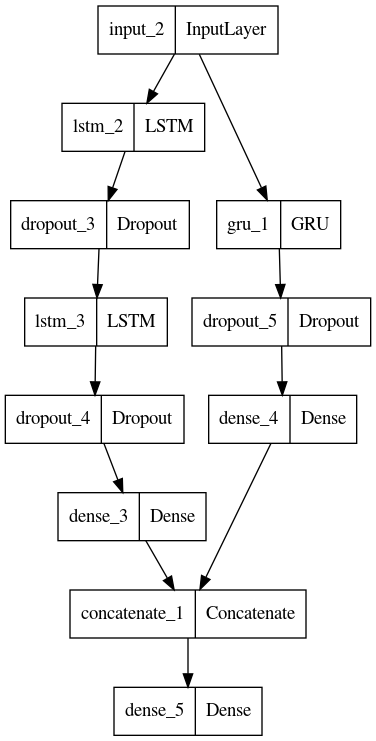

In [47]:
model.summary()
plot_model(model)

In [48]:
#If use validation in this part , then leakage as we are using the normalized values of the training set which in this case would include validation set.
#Validation set needs to be in a tuple with x , y

model.compile(optimizer='adam' , loss = 'mse')

history = model.fit(xrp_train[0] , xrp_train[1] , validation_data = xrp_val  , batch_size = 512  , epochs =100 , verbose = 1 )

Epoch 1/100
45/45 [==============================] - 6s 42ms/step - loss: 0.0056 - val_loss: 0.0016
Epoch 2/100
45/45 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 3/100
45/45 [==============================] - 0s 9ms/step - loss: 7.3990e-04 - val_loss: 0.0034
Epoch 4/100
45/45 [==============================] - 0s 9ms/step - loss: 5.8138e-04 - val_loss: 0.0052
Epoch 5/100
45/45 [==============================] - 0s 9ms/step - loss: 4.7458e-04 - val_loss: 0.0073
Epoch 6/100
45/45 [==============================] - 0s 9ms/step - loss: 4.3389e-04 - val_loss: 0.0076
Epoch 7/100
45/45 [==============================] - 0s 9ms/step - loss: 3.6763e-04 - val_loss: 0.0056
Epoch 8/100
45/45 [==============================] - 0s 9ms/step - loss: 3.5032e-04 - val_loss: 0.0060
Epoch 9/100
45/45 [==============================] - 0s 9ms/step - loss: 3.2140e-04 - val_loss: 0.0056
Epoch 10/100
45/45 [==============================] - 0s 9ms/step - loss: 2.9528

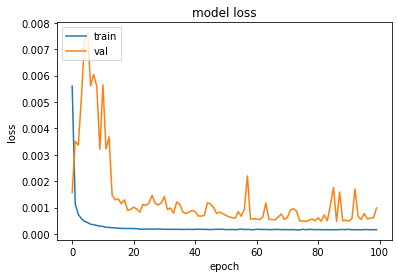

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<Strong> Testing on the validation data once again , hyper-parameter adjustment. <Strong>

In [ ]:
validation_predict = model.predict(xrp_val[0])
validation_predict = scaler.inverse_transform(validation_predict)
print(validation_predict)

In [ ]:
validation_actual = scaler.inverse_transform(xrp_val[1])
validation_actual

In [ ]:
math.sqrt(mean_squared_error(validation_actual , validation_predict))

<Strong> Only do this last , once perfected hyper-parameters. <Strong>

<Strong> Train on both training and validation , then finnaly test on test set. </Strong>

In [ ]:
train_and_val = np.concatenate([xrp_train[0] , xrp_val[0]] )
train_and_val_targets = np.concatenate([xrp_train[1] , xrp_val[1] ])

In [ ]:
final = model.fit(train_and_val , train_and_val_targets , batch_size = 512  , epochs =100 , verbose = 1 )

In [ ]:
test_predict = model.predict(xrp_test[0])

In [ ]:
#Scalling back to the original values 
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform(xrp_test[1])

In [ ]:
math.sqrt(mean_squared_error(test_actual , test_predict))